# Ubung 1

In [15]:
import numpy as np
import pickle
import scipy
import matplotlib.pyplot as plt
import os

In [17]:
LEC_PATH = '/Users/nataliiakodak/downloads/HW9'
os.listdir(LEC_PATH)

['HW9.pdf', 'nonstationary_LDS.pickle', '2DMotion.pickle', '1D_LL.pickle']

In [19]:
with open(os.path.join(LEC_PATH, 'nonstationary_LDS.pickle'), 'rb') as nslds:
    ex1_data = pickle.load(nslds)

ex1_data.keys()

dict_keys(['u', 'sigma', 'rho', 'z'])

In [21]:
len(ex1_data['sigma']), len(ex1_data['rho'])

(1000, 1000)

In [23]:
u_t = np.array(ex1_data['u'])
sigma_t = np.array(ex1_data['sigma'])
rho_t = np.array(ex1_data['rho'])
z_t = np.array(ex1_data['z'])
T = len(u_t)

In [25]:
x_filtered = np.zeros(T)
P_filtered = np.zeros(T)
x_smoothed = np.zeros(T)
P_smoothed = np.zeros(T)

x_filtered[0] = 0 #начальное состояние
P_filtered[0] = 1 #начальная ковар

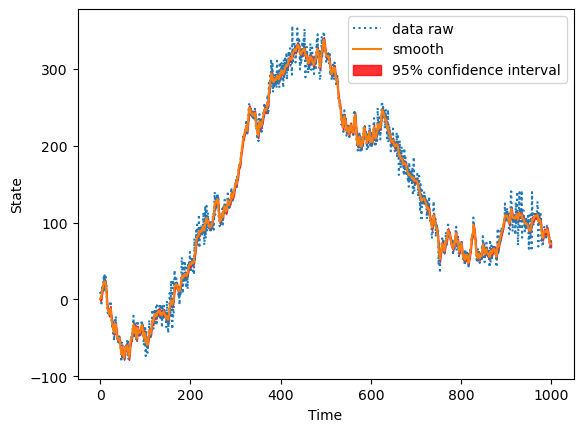

Predicted state mean: 72.23355379896014
Predicted state covariance: 9.985599041236885


In [27]:
for t in range(1, T):
    #прогнозирование
    x_pred = x_filtered[t-1] + u_t[t-1]
    P_pred = P_filtered[t-1] + sigma_t[t-1]
    #updating
    K_t = P_pred / (P_pred + rho_t[t])
    x_filtered[t] = x_pred + K_t * (z_t[t] - x_pred)
    P_filtered[t] = (1 - K_t) * P_pred

x_smoothed[-1] = x_filtered[-1]
P_smoothed[-1] = P_filtered[-1]

for t in range(T-2, -1, -1):
    C_t = P_filtered[t] / (P_filtered[t] + sigma_t[t])
    x_smoothed[t] = x_filtered[t] + C_t * (x_smoothed[t+1] - (x_filtered[t] + u_t[t]))
    P_smoothed[t] = P_filtered[t] + C_t * (P_smoothed[t+1] - (P_filtered[t] + sigma_t[t])) * C_t

#Прогноз на T + 1
pred_stateX = x_smoothed[-1] + u_t[-1]
pred_stateP = P_smoothed[-1] + sigma_t[-1]

time = np.arange(T)
plt.plot(time, z_t, label='data raw', linestyle='dotted')
plt.plot(time, x_smoothed, label='smooth')
plt.fill_between(time, 
                 x_smoothed - 1.96 * np.sqrt(P_smoothed), 
                 x_smoothed + 1.96 * np.sqrt(P_smoothed), 
                 color='red', alpha=0.8, label='95% confidence interval')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

print("Predicted state mean:", pred_stateX)
print("Predicted state covariance:", pred_stateP)

# Ubung 2

In [30]:
with open(f'{LEC_PATH}/2DMotion.pickle', 'rb') as motion2d:
        ex2_data = pickle.load(motion2d)

ex2_data

{'sigma': 10,
 'rho': 1000,
 'y': array([[ -17.64278779,    5.82127328],
        [ -36.13820365,  -35.64277334],
        [  30.11778409,   -9.93116516],
        [  34.28469344,   74.64568612],
        [  30.99932116,   23.04985132],
        [  24.37232458,   49.98893438],
        [  67.7513549 ,   55.26408107],
        [ -10.86084378,   44.11684436],
        [  71.52507334,   91.75735907],
        [ 105.25108066,  100.77658249],
        [  38.09938975,   99.28696663],
        [  41.21816004,   85.59966674],
        [  87.19696361,  103.96728572],
        [ 149.49224358,   67.87530934],
        [ 146.58305681,   74.37846528],
        [ 210.76206279,   64.01626756],
        [ 161.6668844 ,   29.99675857],
        [ 235.58918486,   32.78222579],
        [ 186.07057559,   76.68749792],
        [ 295.36708381,   74.11303117],
        [ 241.3103276 ,   88.77267501],
        [ 332.61402434,   43.93131569],
        [ 310.2090133 ,   29.50832031],
        [ 413.97410402,    4.88118267],
       

In [32]:
sigma = ex2_data['sigma']
rho   = ex2_data['rho']
Delta = ex2_data['Delta']
y     = np.array(ex2_data['y'])
T = y.shape[0]

In [34]:
A = np.array([ [ 1, 0, Delta, 0 ], [ 0, 1, 0, Delta ], [ 0, 0, 1, 0 ], [ 0, 0, 0, 1 ] ])
C = np.array([ [ 1, 0, 0, 0 ], [ 0, 1, 0, 0 ] ])
Q = np.diag([ sigma, sigma, sigma, sigma ])
R = np.diag([ rho, rho ])
use_S = False

In [36]:
def pm(mu_prev, Sigma_prev, y, Sigma_override=None, Sigma_inv_override=None):
    mu_temp = A @ mu_prev
    Sigma   = (A @ Sigma_prev @ A.T + Q) if Sigma_override is None else Sigma_override
    
    if use_S:
        S = C @ Sigma @ C.T + R
        K = Sigma @ C.T @ np.linalg.inv(S)
    else:
        temp = np.linalg.inv(Sigma) + C.T @ np.linalg.inv(R) @ C
        temp = np.linalg.inv(temp)
        temp = temp @ C.T

        K    = temp @ np.linalg.inv(R)
    
    r       = y - C @ mu_temp
    ret     = mu_temp + K @ r
    Sigma_r = (np.identity(4) - K @ C) @ Sigma
    
    return ret, Sigma_r

In [38]:
z = np.hstack((y[0], [0,0]))
Sigma_p = np.diag([ 100000000 ] * 4)
filtered_states = [z]
filtered_covariances = [Sigma_p]

In [40]:
for t in range(1, T):
    z_i, Sigma_p = pm(filtered_states[-1], filtered_covariances[-1], y[t])
    filtered_states.append(z_i)
    filtered_covariances.append(Sigma_p)

filtered_states = np.array(filtered_states)
filtered_covariances = np.array(filtered_covariances)

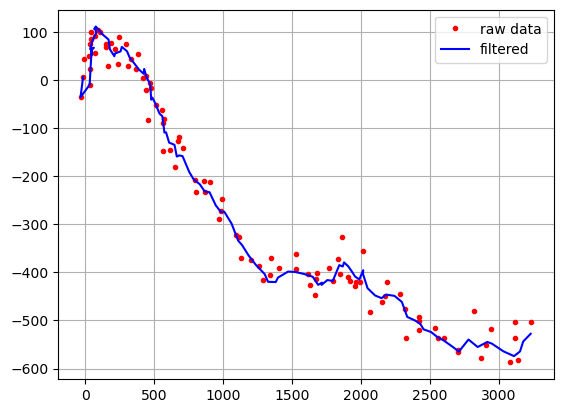

location at T + 1: [3281.69978019 -522.42918941]
covariance at T + 1: [[583.99854504   0.        ]
 [  0.         583.99854504]]


In [42]:
# Прогноз на T + 1
pred_location = A @ filtered_states[-1]
pred_covariance = A @ filtered_covariances[-1] @ A.T + Q

plt.plot(y[:, 0], y[:, 1], 'r.', label='raw data')
plt.plot(filtered_states[:, 0], filtered_states[:, 1], 'b-', label='filtered')
plt.legend()
plt.grid()
plt.show()
print("location at T + 1:", pred_location[:2])
print("covariance at T + 1:", pred_covariance[:2, :2])


# Ubung 3

In [13]:
import os
import pickle
import jax.numpy as jnp
from jax import grad, value_and_grad, hessian
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from jax import jit
from jax.scipy.linalg import solve_triangular

LEC_PATH = '/Users/nataliiakodak/downloads/HW9'
os.listdir(LEC_PATH)

with open(os.path.join(LEC_PATH, '1D_LL.pickle'), 'rb') as nslds:
    data = pickle.load(nslds)

data.keys()
z = jnp.array(data['z'])
T = len(z)

initial_sigma = 1.0#jnp.std(z) / 2
initial_rho = 1.0#jnp.std(z) / 2
initial_guess = jnp.array([initial_sigma, initial_rho])

In [15]:
def log_likelihood(params):
     sigma, rho = params
     A = jnp.zeros((T-1, T-1))
     for i in range(T-1):
        A = A.at[i, i].set(sigma**2 + rho**2)
        if i < T - 2:
            A = A.at[i, i+1].set(-sigma**2)
            A = A.at[i+1, i].set(-sigma**2)
    
     A_inv = jnp.linalg.inv(A)
     b = z[1:] - z[:-1]
    
    
     raz = - (T + 1) * jnp.log(jnp.sqrt(2 * jnp.pi) * rho)
     dwa = - T * jnp.log(jnp.sqrt(2 * jnp.pi) * sigma)
     tri = jnp.dot(b, solve_triangular(A, b, lower=True))
     chetire = - jnp.log(jnp.sqrt(jnp.transpose(2*jnp.pi))/jnp.linalg.det(A))
    
     log_p = raz + dwa + tri + chetire
     
     return -log_p


In [17]:
result = minimize(log_likelihood, initial_guess, jac=grad(log_likelihood), method='BFGS')

sigma_opt, rho_opt = result.x
print("Optimal sigma:", sigma_opt)
print("Optimal rho:", rho_opt)

Optimal sigma: 0.2571579312965261
Optimal rho: 1.6843140382706663
